In [4]:
import numpy as np
import pandas as pd
from pandas_datareader import data as web
import datetime
%matplotlib inline
import matplotlib.pyplot as plt
from pydmd import DMD

In [141]:
stocks = ['HDFCBANK.NS','ICICIBANK.NS','AXISBANK.NS','KOTAKBANK.NS','INDUSINDBK.NS'
,"SBIN.NS"]

In [142]:
start_date = (datetime.datetime.now() - datetime.timedelta(days=365*5)).strftime("%m-%d-%Y")

In [143]:
start_date

'05-12-2017'

In [144]:
df=pd.DataFrame()

In [145]:
for stock in stocks:
    start_date = (datetime.datetime.now() - datetime.timedelta(days=365*5)).strftime("%m-%d-%Y")
    data = web.DataReader(stock, data_source='yahoo', start=start_date)
    df[stock]=data['Adj Close']

  

In [146]:
df.tail()

,HDFCBANK.NS,ICICIBANK.NS,AXISBANK.NS,KOTAKBANK.NS,INDUSINDBK.NS,SBIN.NS
Date,,,,,,
2022-05-05,1352.949951,728.799988,702.349976,1797.599976,936.799988,480.000000
2022-05-06,1317.599976,719.250000,673.400024,1775.300049,915.400024,483.950012
2022-05-09,1319.849976,710.349976,663.700012,1767.500000,889.700012,475.899994
2022-05-10,1341.050049,711.299988,659.750000,1797.150024,910.750000,475.200012
2022-05-11,1348.599976,714.200012,672.349976,1809.949951,923.349976,476.549988


In [147]:
data=df.to_numpy().T
data.shape

(6, 1235)

In [148]:
dmd = DMD(svd_rank=50)
dmd.fit(data)

Eigenvalue (0.9990858180576077+0.001371278358373534j): distance from unit circle 0.0018256477518248104
Eigenvalue (0.9990858180576077-0.001371278358373534j): distance from unit circle 0.0018256477518248104
Eigenvalue (0.9975391406830313+0j): distance from unit circle 0.004915662805359489
Eigenvalue (0.9815670947941443+0j): distance from unit circle 0.03652603841738333
Eigenvalue (0.9679477520436633+0j): distance from unit circle 0.06307714931361885
Eigenvalue (0.9466844457911393+0j): distance from unit circle 0.10378856009712345


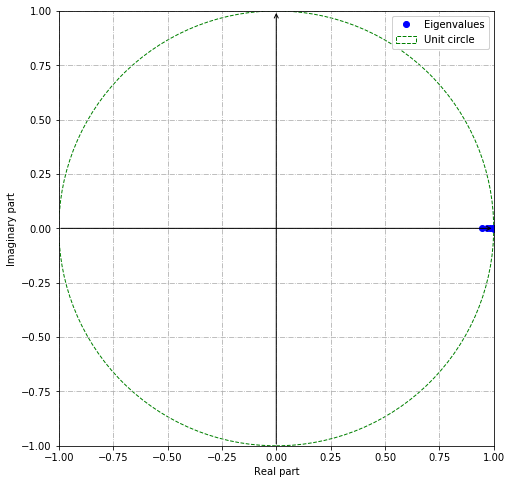

In [149]:
for eig in dmd.eigs:
    print('Eigenvalue {}: distance from unit circle {}'.format(eig, np.abs(eig.imag**2+eig.real**2 - 1)))

dmd.plot_eigs(show_axes=True, show_unit_circle=True)

In [150]:
dmd.fit(data)
dmd.original_time['dt'] = dmd.dmd_time['dt'] = 1
dmd.original_time['t0'] = dmd.dmd_time['t0'] = 1
dmd.original_time['tend'] = dmd.dmd_time['tend'] = 1235

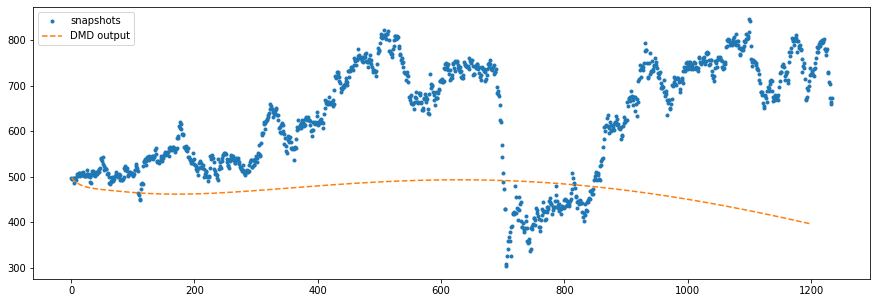

In [151]:
dmd.dmd_time['tend'] = 1200

fig = plt.figure(figsize=(15, 5))
plt.plot(data[2][:], '.', label='snapshots')
plt.plot(dmd.dmd_timesteps, dmd.reconstructed_data[2][:].real, '--', label='DMD output')
plt.legend()
plt.show()

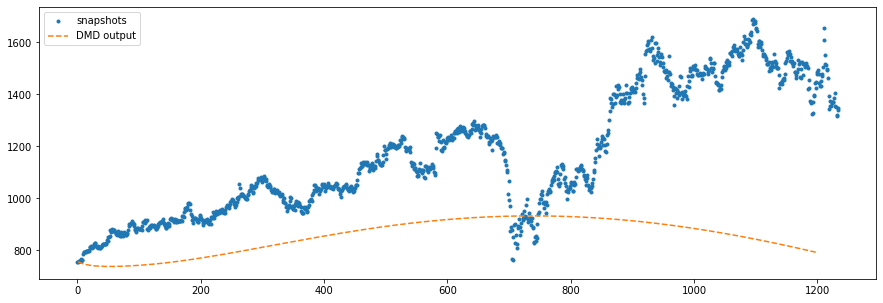

In [152]:
dmd.dmd_time['tend'] = 1200

fig = plt.figure(figsize=(15, 5))
plt.plot(data[0][:], '.', label='snapshots')
plt.plot(dmd.dmd_timesteps, dmd.reconstructed_data[0][:].real, '--', label='DMD output')
plt.legend()
plt.show()

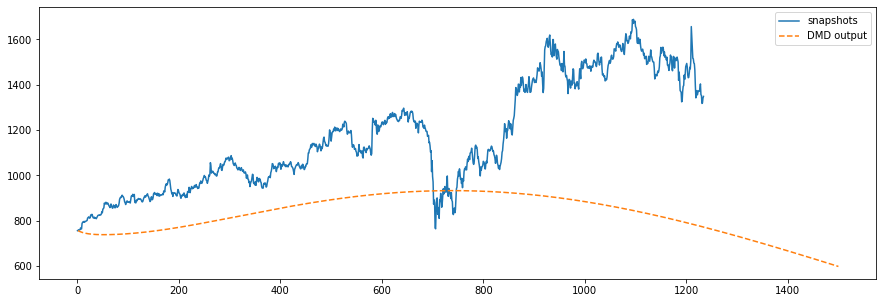

In [153]:
dmd.dmd_time['tend'] = 1500

fig = plt.figure(figsize=(15, 5))
plt.plot(data[0][:], label='snapshots')
plt.plot(dmd.dmd_timesteps, dmd.reconstructed_data[0][:].real, '--', label='DMD output')
plt.legend()
plt.show()

In [154]:
def pred(x,w):
    dmd_p=DMD(svd_rank=10)
    x_hat=x.copy()
    for i in range(data.shape[1]-2*w+1):
        dmd_p.fit(x[:,i:i+w])
    
        x_hat[:,i+w]=dmd_p.reconstructed_data[:,-1]
    return (x_hat[:,w:-2*w+1],x[:,w:-2*w+1])


C:\Users\Sivamaran\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: ComplexWarning: Casting complex values to real discards the imaginary part
  import sys
C:\Users\Sivamaran\Anaconda3\lib\site-packages\pydmd\dmdbase.py:126: RuntimeWarning: invalid value encountered in log
  omega = old_div(np.log(self.eigs), self.original_time['dt'])


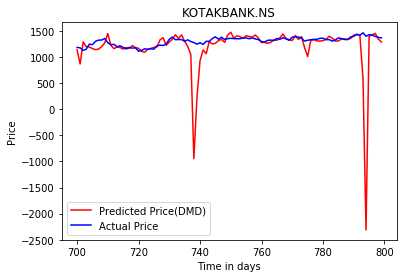

In [155]:
(x_hat,x)=pred(data,20)
plt.plot(range(700,800),np.real(x_hat[3,700:800]),color='red',label='Predicted Price(DMD)')
plt.plot(range(700,800),x[3,700:800],color='blue',label='Actual Price')
plt.xlabel("Time in days")
plt.ylabel("Price")
plt.title(stocks[3])
plt.legend()

In [156]:
import scipy as sc


In [160]:
mape=np.abs(x-x_hat)/x
mape=np.nan_to_num(mape)
#mape=np.sum(mape,axis=1)/mape.shape[1]
mape[1,20]

0.005307273661499296

C:\Users\Sivamaran\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  """Entry point for launching an IPython kernel.


Text(0.5, 1.0, 'HDFCBANK.NS')

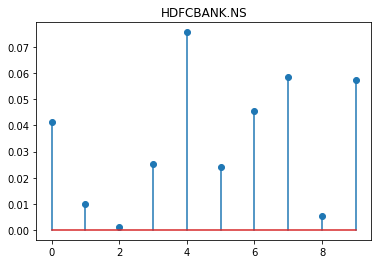

In [159]:
plt.stem(mape[0,-10:])
plt.title(stocks[0])

In [161]:
from statsmodels.tsa.arima.model import ARIMA

In [162]:
arima_pred=[]
for i in range(250,300):
    model=ARIMA(data[1,i:i+10],order=(1,1,0))
    model_fit=model.fit()
    forcast=model_fit.forecast(1)
    arima_pred.append(forcast)

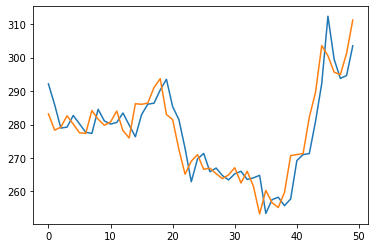

In [163]:
arima_pred=np.array(arima_pred)
plt.plot(arima_pred)
plt.plot(data[1,260:310])

In [164]:
m=np.abs(arima_pred-data[1,260:310])/data[1,260:310]
mape=np.nan_to_num(m)
mape[1,20]
#ma=np.sum(mape,axis=1)/mape.shape[1]
#ma

0.016022360607314073